In [3]:
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import itertools as it
import scipy.stats as stats
from pathlib import Path
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.manifold import TSNE

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo

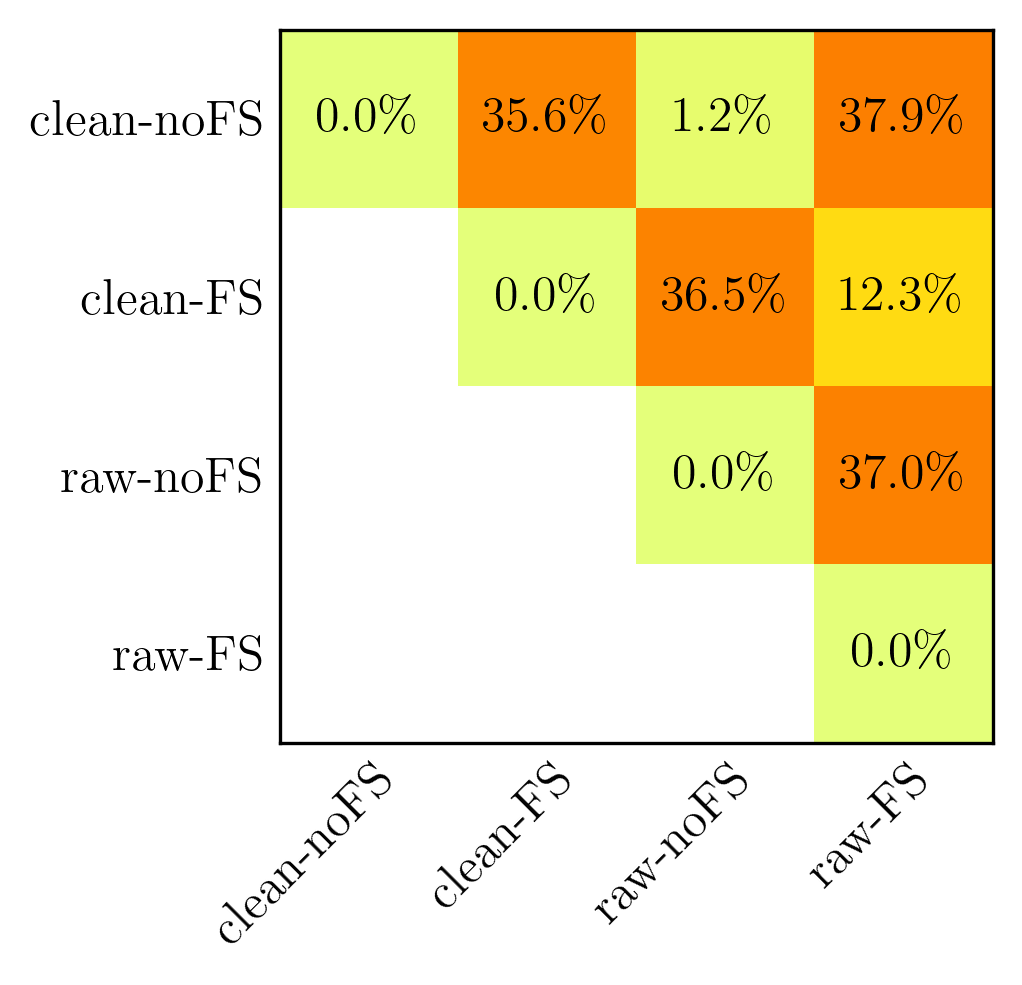

In [16]:
data = np.array([  [0,          0.35648,        0.01215,     0.37905],
                    [np.nan,    0,              0.36516,     0.12326],
                    [np.nan,    np.nan,         0,           0.37037],
                    [np.nan,    np.nan,         np.nan,      0]]       )
data *= 100
fig, ax = plt.subplots(figsize=(3.5,3.5), dpi=300)
im = ax.imshow(data, cmap='Wistia', interpolation='nearest')

for (i, j), val in np.ndenumerate(data):
    if not np.isnan(val): 
        ax.text(j, i, f"{val:.1f}\\%", ha='center', va='center', color='black', fontsize=12) 
    
xticks = range(data.shape[1])
ax.set_xticks([x + 0.2 for x in xticks])
ax.set_yticks(range(data.shape[0]))
ax.set_xticklabels(["clean-noFS", "clean-FS", "raw-noFS", "raw-FS"], rotation=45, ha='right', fontsize = 12)
ax.set_yticklabels(["clean-noFS", "clean-FS", "raw-noFS", "raw-FS"], fontsize = 12)
ax.tick_params(axis='both', length=0)


# ax.set_title("The ratio of significantly different learning curves between the two versions of our LCDB 1.1 dataset. ")

plt.tight_layout()
plt.show()


In [4]:
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_clean.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5']
dataset_1, dataset_2 = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]

In [ ]:
diff_matrix = np.full((24, 72), np.nan)

for data_idx in range(72):
    for learner_idx in range(24):
        lc_clean = dataset_1[data_idx, learner_idx, :, :, :, 1].reshape(-1, 137)
        lc_real = dataset_2[data_idx, learner_idx, :, :, :, 1].reshape(-1, 137)

        mask_indices = np.any((~np.isnan(lc_clean)) & (~np.isnan(lc_real)), axis=0)
        num_anchor = np.count_nonzero(mask_indices)
        lc_clean = lc_clean[:, mask_indices]
        lc_real = lc_real[:, mask_indices]

        if num_anchor == 0: 
            diff_matrix[learner_idx, data_idx] = 1

        else:
            corrected_p_value_list = []
            for anchor_idx in range(num_anchor):
                if (lc_clean[:, anchor_idx] == lc_real[:, anchor_idx]).all():
                    corrected_p_value = 1
                else: 
                    t_stat, p_value = ttest_ind(lc_clean[:, anchor_idx], lc_real[:, anchor_idx])
                    corrected_p_value = p_value * num_anchor    # Bonferroni correction
                
                corrected_p_value_list.append(corrected_p_value)
            if any(p < 0.05 for p in corrected_p_value_list):
                diff_matrix[learner_idx, data_idx] = 0
            else: 
                diff_matrix[learner_idx, data_idx] = 1

print(np.sum(diff_matrix == 0) / diff_matrix.size)

C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


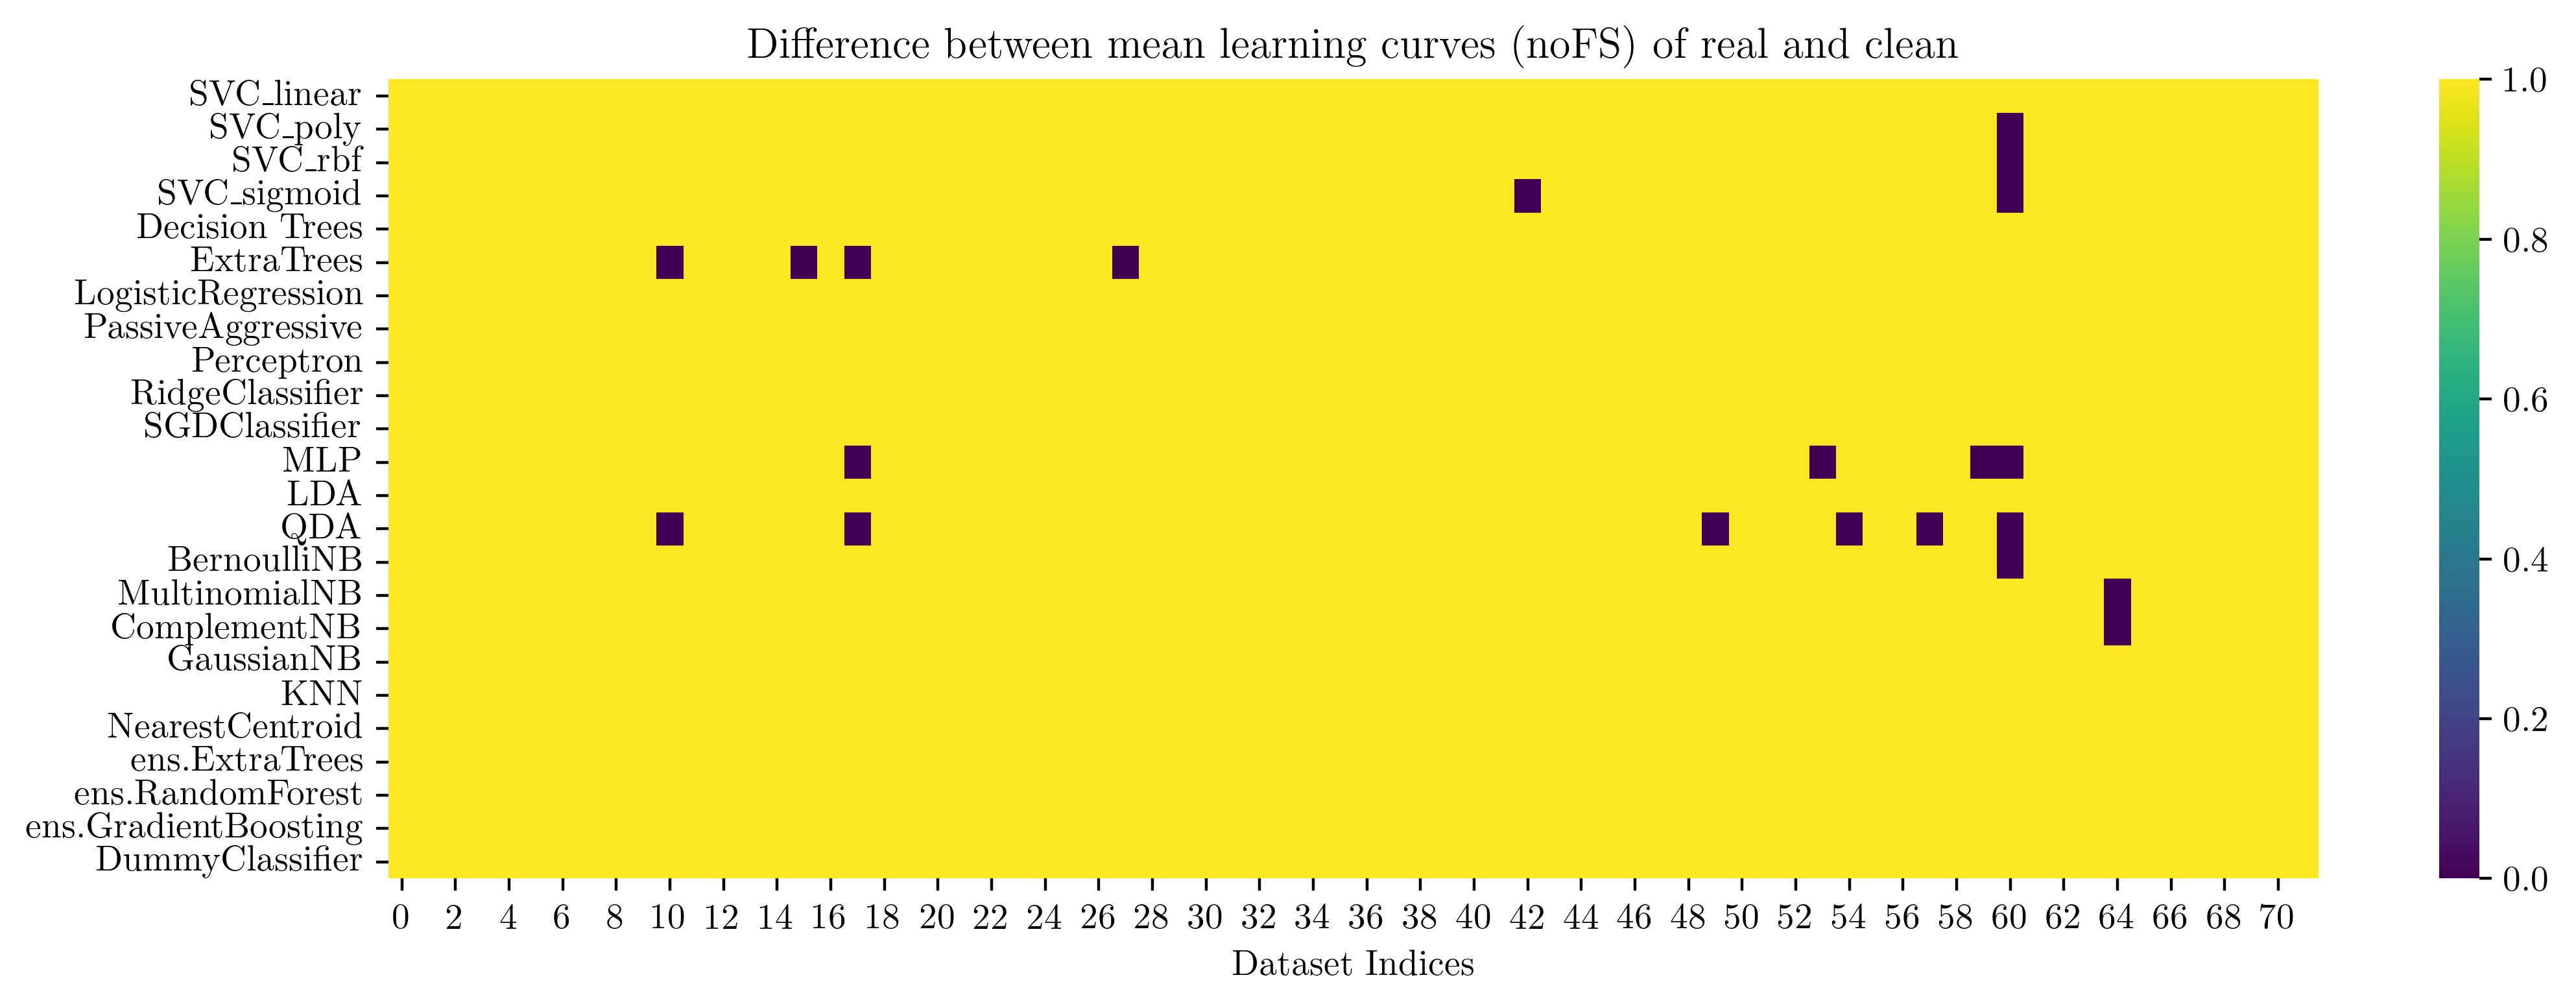

In [ ]:
plt.figure(figsize=(12, 4), dpi = 400)
ax = sns.heatmap(diff_matrix, cmap="viridis", annot=False, cbar=True, vmin=0, vmax=1)
# y tick align
yticks = range(len(learner_zoo))
ax.set_yticks([y + 0.5 for y in yticks])
ax.set_yticklabels(learner_zoo, rotation=0)

# plt.title('Difference between mean learning curves (noFS) of real and clean')
plt.xlabel('Dataset Indices')
plt.show()

### t-SNE

In [34]:
file_paths = [  '../dataset/LCDB11_ER_CC18_noFS_real.hdf5',
                '../dataset/LCDB11_ER_CC18_minmaxFS_real.hdf5', 
                '../dataset/LCDB11_ER_CC18_standardFS_real.hdf5']
dataset_1, dataset_2, dataset_3 = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]



In [35]:
def rescale_to_100(data):
    rescaled_data = []
    for sample in data:  
        interpolated_sample = []
        for series in sample.T:  
            non_nan_indices = np.where(~np.isnan(series))[0]
            non_nan_values = series[non_nan_indices]
            
            if len(non_nan_values) < 2:
                interpolated_sample.append(np.zeros(100))
                continue
            
            interp_func = interp1d(non_nan_indices, non_nan_values, kind='linear', fill_value="extrapolate")
            
            new_indices = np.linspace(non_nan_indices[0], non_nan_indices[-1], 100)
            interpolated_series = interp_func(new_indices)
            interpolated_sample.append(interpolated_series)
        
        rescaled_data.append(np.array(interpolated_sample).T)
    
    return np.array(rescaled_data)

C:\Users\cyan1\AppData\Local\Temp\ipykernel_3776\4025514660.py:3: RuntimeWarning: Mean of empty slice
  rescale_to_100(np.nanmean(dataset[:, LEARNER, :, :, :, :], axis=(1, 2)))[:, :, 1].reshape(72, 100)


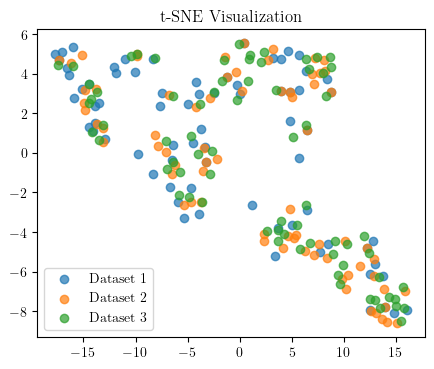

In [38]:
LEARNER = 11
data = np.vstack([
    rescale_to_100(np.nanmean(dataset[:, LEARNER, :, :, :, :], axis=(1, 2)))[:, :, 1].reshape(72, 100)
    for dataset in [dataset_1, dataset_2, dataset_3]
])

labels = np.array([i + 1 for i in range(3) for _ in range(72)])

tsne = TSNE(n_components=2, perplexity=30) 
data_2d = tsne.fit_transform(data)

plt.figure(figsize=(5, 4))
for i in range(1, 4):
    plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1], label=f'Dataset {i}', alpha=0.7)
plt.legend()
plt.title('t-SNE Visualization')
plt.show()

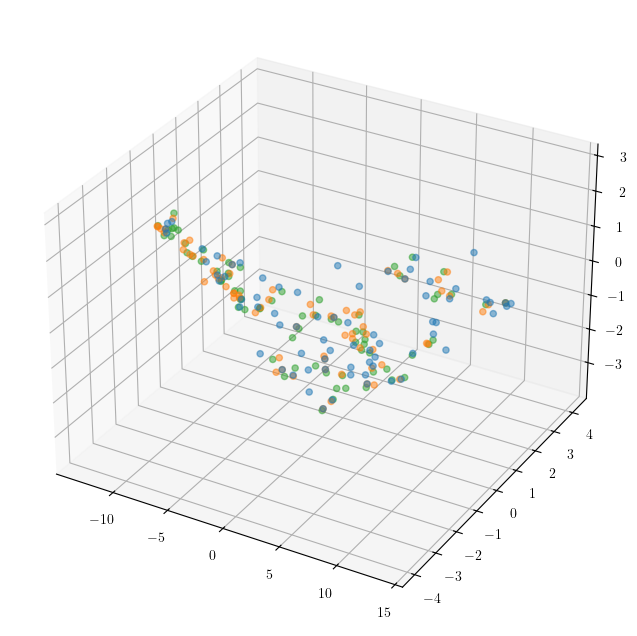

In [40]:
tsne = TSNE(n_components=3, perplexity = 20)   # less feature, less perplexity
embedded_data = tsne.fit_transform(data)

# Visualize the t-SNE result in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(labels):
    indices = np.where(labels == label)
    ax.scatter(embedded_data[indices, 0], embedded_data[indices, 1], embedded_data[indices, 2], label=label, alpha=0.5)

plt.show()